In [1]:
import os
import random
import json
import requests
from pathlib import Path

from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Import Mask RCNN
from detector.mrcnn import visualize
import detector.mrcnn.model as modellib
from detector.mrcnn import utils

import lego

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

2022-02-21 22:47:02.720429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


'2.5.3'

In [2]:
import os
from PIL import Image, ImageDraw, ImageFont

def render_detections(image, boxes, masks, class_ids, scores, class_names, image_name=None, filter_classs_names=None,
               scores_thresh=0.1, save_dir=None, mode=0):
    """
        image: image array
        image_name: image name
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [num_instances, height, width]
        class_ids: [num_instances]
        scores: confidence scores for each box
        class_names: list of class names of the dataset
        filter_classs_names: (optional) list of class names we want to draw
        scores_thresh: (optional) threshold of confidence scores
        save_dir: (optional) the path to store image
        mode: (optional) select the result which you want
                mode = 0 , save image with bbox,class_name,score and mask;
                mode = 1 , save image with bbox,class_name and score;
                mode = 2 , save image with class_name,score and mask;
                mode = 3 , save mask with black background;
    """
    mode_list = [0, 1, 2, 3]
    assert mode in mode_list, "mode's value should in mode_list %s" % str(mode_list)

    if save_dir is None and image_name is not None:
        save_dir = os.path.join(os.getcwd(), "output")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    useful_mask_indices = []

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(N):
        # filter
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        if score is None or score < scores_thresh:
            continue

        label = class_names[class_id]
        if (filter_classs_names is not None) and (label not in filter_classs_names):
            continue

        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        useful_mask_indices.append(i)

    if len(useful_mask_indices) == 0:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return

    colors = visualize.random_colors(len(useful_mask_indices))

    if mode != 3:
        masked_image = image.astype(np.uint8).copy()
    else:
        masked_image = np.zeros(image.shape).astype(np.uint8)

    if mode != 1:
        for index, value in enumerate(useful_mask_indices):
            masked_image = visualize.apply_mask(masked_image, masks[:, :, value], colors[index])

    masked_image = Image.fromarray(masked_image)

    if mode == 3:
        if image_name is not None:
            masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
        return masked_image

    draw = ImageDraw.Draw(masked_image)
    colors = np.array(colors).astype(int) * 255

    for index, value in enumerate(useful_mask_indices):
        class_id = class_ids[value]
        score = scores[value]
        label = class_names[class_id]

        y1, x1, y2, x2 = boxes[value]
        if mode != 2:
            color = tuple(colors[index])
            draw.rectangle((x1, y1, x2, y2), outline=color)

        # Label
        # font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
        # draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255), font)
        draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255))

    if image_name is not None:
        masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
    return masked_image

In [3]:
REPO_URL = 'https://api.github.com/repos/LilDataMonster/Lego-CNN/releases/latest'
response = json.loads(requests.get(REPO_URL).text)

In [4]:
# LEGO_WEIGHTS_URL = response['assets'][0]['browser_download_url']
LEGO_WEIGHTS_URL = "https://github.com/LilDataMonster/Lego-CNN/releases/download/v0.0.3/mask_rcnn_lego_0200.h5"
LEGO_WEIGHTS_NAME = os.path.basename(LEGO_WEIGHTS_URL)

LEGO_WEIGHTS_PATH = Path(os.path.join("logs", "weights", LEGO_WEIGHTS_NAME))

weights_response = requests.get(LEGO_WEIGHTS_URL, stream=True)
total_size_in_bytes= int(weights_response.headers.get('content-length', 0))
progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
if not LEGO_WEIGHTS_PATH.exists():
    # Streaming, so we can iterate over the response.
    block_size = 1024 #1 Kibibyte
    with open(LEGO_WEIGHTS_PATH, 'wb') as file:
        for data in weights_response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR downloading pretrained weights")
progress_bar.close()

  0%|                                                                                     | 0.00/262M [00:00<?, ?iB/s]


In [5]:
class InferenceConfig(lego.LegoConfig().__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [6]:
model = modellib.MaskRCNN(mode="inference", model_dir="", config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


2022-02-21 22:47:09.800081: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-21 22:47:09.860404: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-21 22:47:09.860437: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: TRLPanda
2022-02-21 22:47:09.860443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: TRLPanda
2022-02-21 22:47:09.860681: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.0
2022-02-21 22:47:09.860713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.0
2022-02-21 22:47:09.860719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.82.0


Loading weights  logs/weights/mask_rcnn_lego_0200.h5


2022-02-21 22:47:11.091443: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 22:47:11.490224: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3493010000 Hz


In [7]:
VALIDATION_DATASET_DIR = os.path.join('dataset', 'test')

valid_dataset = lego.LegoDataset()
valid_dataset.load_coco(VALIDATION_DATASET_DIR, "minival")

valid_dataset.prepare()
print("Images: {}\nClasses: {}".format(len(valid_dataset.image_ids), valid_dataset.class_names))

loading annotations into memory...
Done (t=1.65s)
creating index...
index created!
Images: 2500
Classes: ['BG', '2431', '3003', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3069', '3070', '3176', '3622', '3700', '3710', '3958', '4150', '4274', '6141', '11211', '11476', '11477', '15068', '15573', '22885', '24201', '24246', '25269', '29119', '29120', '33909', '35480', '36840', '47458', '47905', '85984', '87079', '87087', '87580', '93273', '98138', '99206']


In [8]:
# dataset = lego.LegoDataset()
# dataset.prepare()
#dataset.class_names
class_names = ['BG', '2431', '3003', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3069', '3070', '3176', '3622', '3700', '3710', '3958', '4150', '4274', '6141', '11211', '11476', '11477', '15068', '15573', '22885', '24201', '24246', '25269', '29119', '29120', '33909', '35480', '36840', '47458', '47905', '85984', '87079', '87087', '87580', '93273', '98138', '99206']

In [9]:
image_id = random.choice(valid_dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(valid_dataset, config, image_id)
info = valid_dataset.image_info[image_id]

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, valid_dataset.image_reference(image_id)))

image ID: coco.1060 (1060) http://cocodataset.org/#explore?id=1060


In [10]:
results = model.detect([image], verbose=1)[0]

Processing 1 images
image                    shape: (832, 832, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 55)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.21783  max:    1.14082  float32


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-02-21 22:47:16.869375: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -48 } dim { size: -308 } dim { size: -309 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\007\000\000\000\00

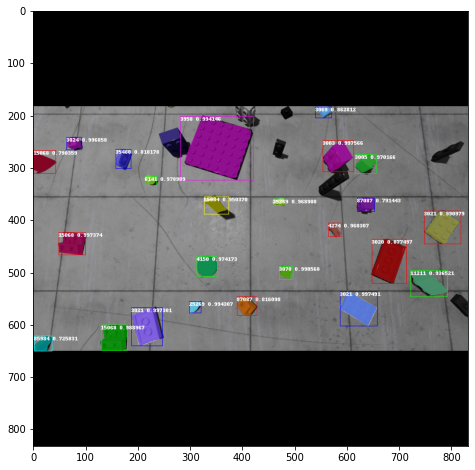

In [11]:
output_image = render_detections(image, results['rois'], results['masks'], results['class_ids'], results['scores'], valid_dataset.class_names, filter_classs_names=None, scores_thresh=0.1, save_dir=None, mode=0)

plt.figure(figsize=(16,8))
plt.imshow(output_image)

In [12]:
print("gt_class_id", gt_class_id)
print("gt_bbox", gt_bbox)
print("gt_mask", gt_mask)

gt_class_id [36  1  5 16 23 24 23  8 23 19 17 18  2 25 10 28 42  2 20 15 32  8  6 28
  9 11  9 38 35 38  6  6]
gt_bbox [[621   0 650  36]
 [353 327 385 368]
 [435 647 521 714]
 [200 289 322 420]
 [269   0 308  44]
 [541 798 585 832]
 [601 129 650 180]
 [249 760 289 825]
 [423  48 465 101]
 [315 214 331 235]
 [468 313 507 352]
 [406 565 430 589]
 [223 241 278 299]
 [182 387 221 426]
 [182 538 204 571]
 [358 458 370 480]
 [182 261 185 270]
 [248 554 309 612]
 [497 724 546 795]
 [298 547 352 606]
 [264 157 300 187]
 [244 458 280 484]
 [380 749 445 816]
 [554 299 578 320]
 [240  64 264  91]
 [487 471 512 495]
 [182 473 207 497]
 [274 616 309 657]
 [546 390 583 425]
 [356 620 385 653]
 [535 585 602 658]
 [565 189 641 246]]
gt_mask [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False F

In [13]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, results['rois'], results['class_ids'], results['scores'], results['masks'])

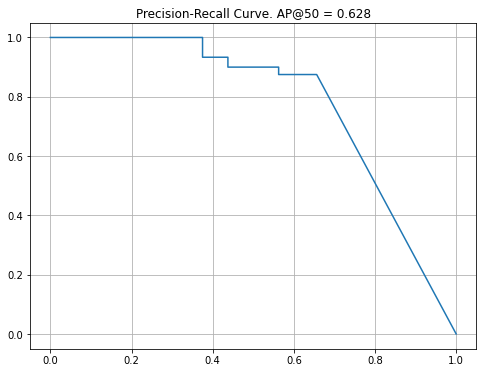

In [14]:
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions)
plt.title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
plt.grid()

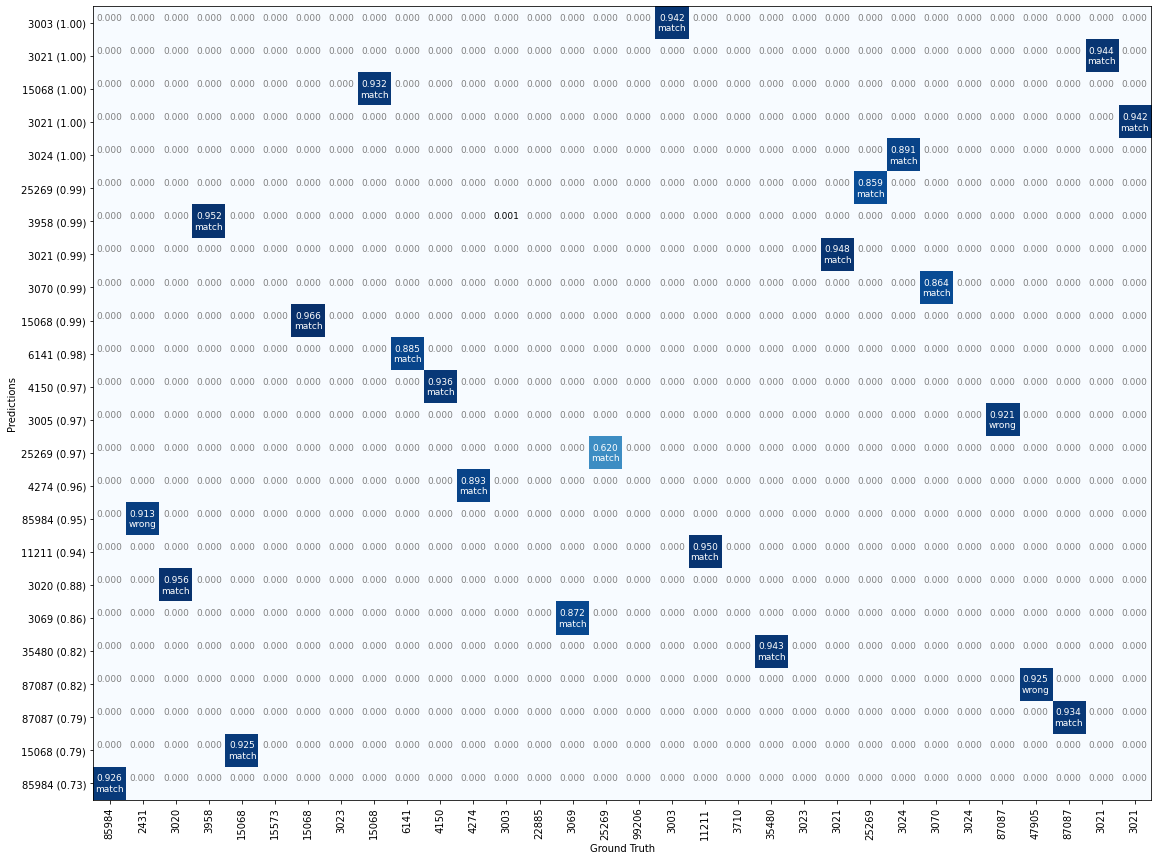

In [15]:
plt.figure(figsize=(16,16))
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, results['class_ids'], results['scores'], overlaps, valid_dataset.class_names, 0.1)

In [16]:
import pandas as pd

In [17]:
df = pd.DataFrame(overlaps)
# df.loc['ground_truth'] = [int(valid_dataset.class_names[idx]) for idx in gt_class_id]
# df['predictions'] = [int(valid_dataset.class_names[idx]) for idx in results['class_ids']] + [0]
df.loc['ground_truth'] = gt_class_id
df['predictions'] = np.append(results['class_ids'], -1)
df = df.sort_values(by=['predictions'])
df = df.sort_values(by=['ground_truth'], axis=1)
# display(df)

gt_sorted = df.loc['ground_truth'][1:].astype(int).values
df = df.drop(index='ground_truth')

pred_sorted = df['predictions'].values
df = df.drop(columns='predictions')

display(df)

,1,17,12,2,22,31,30,21,7,26,...,5,13,15,23,20,28,0,27,29,16
0,0.000000,0.941642,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.921084,0.000000,0.0
17,0.000000,0.000000,0.000000,0.955614,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.942118,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.947746,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.943789,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,0.000000,0.000000,0.000504,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


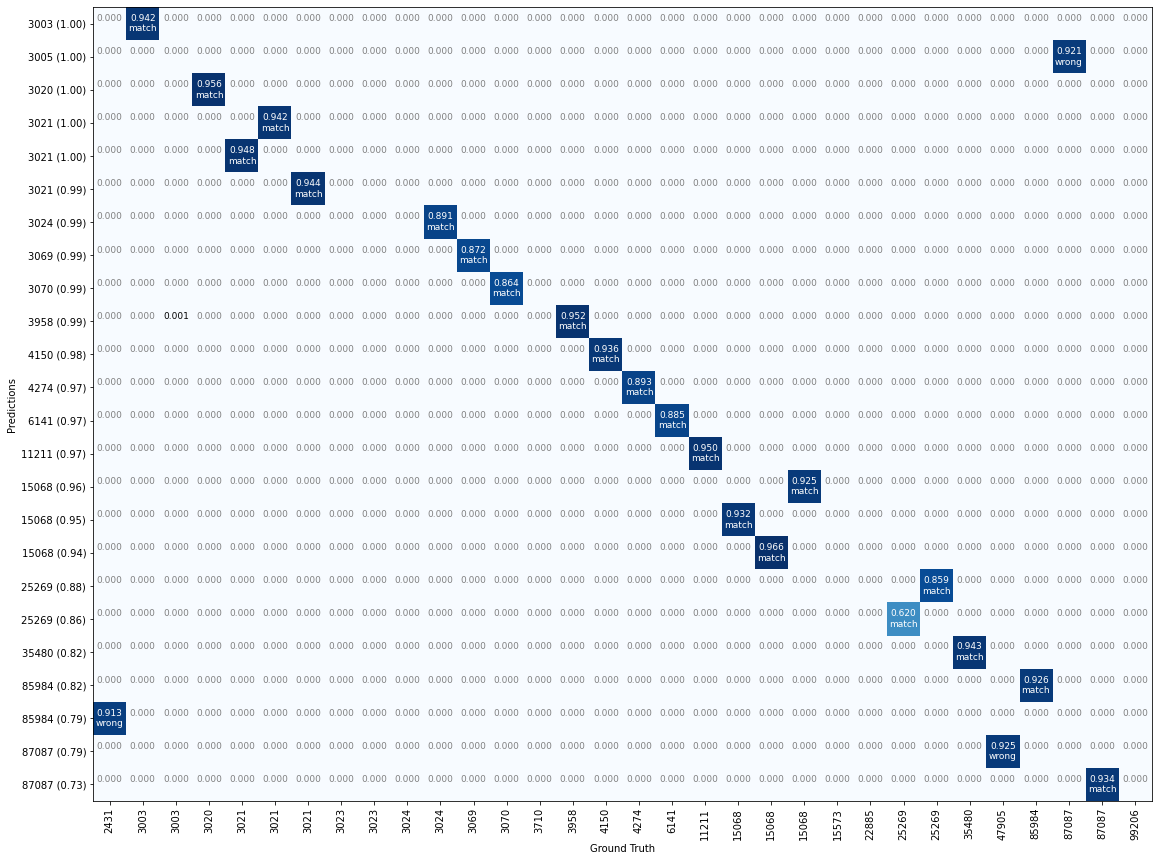

In [18]:
# display(df)
plt.figure(figsize=(16,16))
visualize.plot_overlaps(gt_sorted, pred_sorted, results['scores'], df.values, valid_dataset.class_names, 0.1)

Compute mAP @ IoU=50 on Batch of Images

In [19]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids, dataset):
    APs = []
    ret_results = []
    for image_id in tqdm(image_ids):
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)#, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        
        # Compute AP
        r = results[0]
        ret_results.append(r)
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs, ret_results

In [20]:
# Pick a set of random images
image_ids = np.random.choice(valid_dataset.image_ids, 10)
# image_ids = valid_dataset.image_ids
APs, results = compute_batch_ap(image_ids, valid_dataset)
print("mAP @ IoU=50: ", np.mean(APs))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.44s/it]

mAP @ IoU=50:  0.5442148453392307


In [21]:

# # Validation dataset
# dataset_val = LegoDataset()
# val_type = "val" if args.year in '2017' else "minival"
# coco = dataset_val.load_coco(args.dataset, val_type, year=args.year, return_coco=True, auto_download=args.download)
# dataset_val.prepare()
# print("Running COCO evaluation on {} images.".format(args.limit))


VALIDATION_DATASET_DIR = os.path.join('dataset', 'test')

valid_dataset = lego.LegoDataset()
coco = valid_dataset.load_coco(VALIDATION_DATASET_DIR, "minival", return_coco=True)

valid_dataset.prepare()
print("Images: {}\nClasses: {}".format(len(valid_dataset.image_ids), valid_dataset.class_names))

limit = 10
lego.evaluate_coco(model, valid_dataset, coco, "bbox", limit=limit)

loading annotations into memory...
Done (t=1.59s)
creating index...
index created!
Images: 2500
Classes: ['BG', '2431', '3003', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3069', '3070', '3176', '3622', '3700', '3710', '3958', '4150', '4274', '6141', '11211', '11476', '11477', '15068', '15573', '22885', '24201', '24246', '25269', '29119', '29120', '33909', '35480', '36840', '47458', '47905', '85984', '87079', '87087', '87580', '93273', '98138', '99206']


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.05s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.851
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10